In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest




import ast
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from keras.models import Sequential
from autoencoder_module import AutoEncoder
from Data import train_test_split_count_matrix_baseline, count_matrix, train_test_split_count_matrix_for_LSTM
import h5py
from Analysis import roc_curve_for_analysis
from math import ceil

In [2]:
def prepare_data_for_analysis(path, BGL):
    data_df = pd.read_csv(path)
    if BGL:
        data_df.drop(columns='new label', inplace = True)
    #Converting the labels to binary numbers, 0 for success, 1 for failure
    mask = data_df['Final Label'] == 'Success'
    data_df.loc[mask, 'label'] = 0
    data_df.loc[~mask, 'label'] = 1
    #I do not need the index column
    data_df = data_df.reset_index(drop=True)

    data_df['Events']  = data_df['New Event ID'].apply(ast.literal_eval)
    #Calculating the maximum value of the En type events
    max_n = max(int(e[1:]) for sublist in data_df['Events'] for e in sublist)
    data_df['Event_Count_Matrix'] = data_df['Events'].apply(lambda x: count_matrix(x, max_n))
    x_data = data_df['Event_Count_Matrix'].to_list()
    y_data = data_df['label'].to_list()
    return x_data, y_data

In [3]:
path = '../Data/BGL/Processed_data/processed_labeled_data.csv'
x_data, y_data = prepare_data_for_analysis(path, True)

(array([6.9246e+04, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e+00, 1.523380e+04, 3.046660e+04, 4.569940e+04,
        6.093220e+04, 7.616500e+04, 9.139780e+04, 1.066306e+05,
        1.218634e+05, 1.370962e+05, 1.523290e+05]),
 <BarContainer object of 10 artists>)

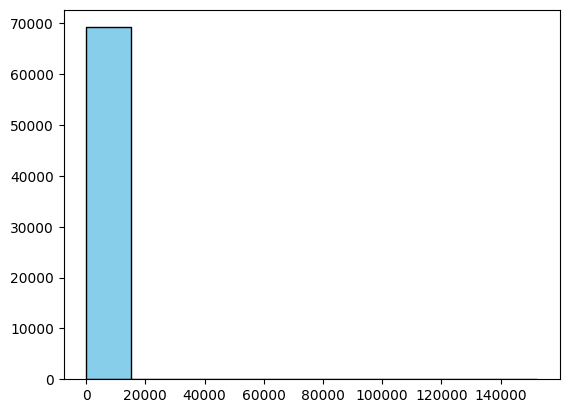

In [4]:
lengths = []
for i in range(len(x_data)):
    lengths.append(len(x_data[i]))
plt.hist(lengths, color='skyblue', edgecolor='black')
#plt.xlim([0,20000])

In [5]:
def calculate_anomaly_ratio_under_length(length, x_data, y_data):
    non_anomaly = 0
    anomaly = 0
    for i in range(len(x_data)):
        if len(x_data[i]) <= length:
            if y_data[i] == 1:
                anomaly += 1
            else:
                non_anomaly += 1
    return non_anomaly, anomaly

In [6]:
anomalies = np.zeros(20001)
nonanomaly_logs = np.zeros(20001)
number_of_lengths = np.linspace(start = 0, stop = 20000, num=20001)
for i in range(20001):
    non_anomaly, anomaly = calculate_anomaly_ratio_under_length(number_of_lengths[i], x_data, y_data)
    nonanomaly_logs[i] = non_anomaly
    anomalies[i] = anomaly

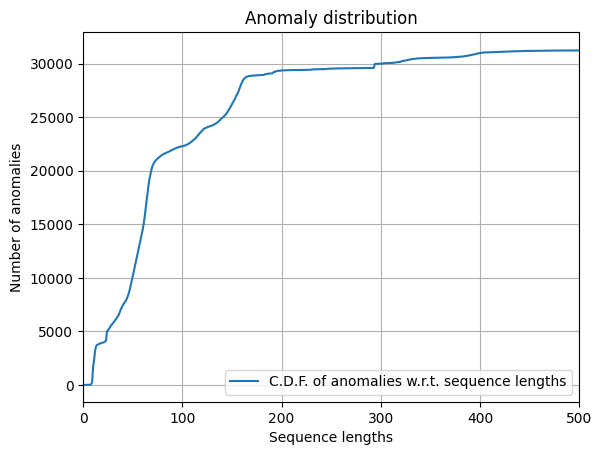

In [7]:
plt.plot(number_of_lengths, anomalies, label = 'C.D.F. of anomalies w.r.t. sequence lengths')
plt.xlabel('Sequence lengths')  # Adjust the x-axis title
plt.ylabel('Number of anomalies')  # Adjust the y-axis title
plt.title('Anomaly distribution')  # Adjust the plot title

# Add a legend
plt.legend()

# Add gridlines
plt.grid(True)
plt.xlim([0,500])
# Display the plot
plt.show()

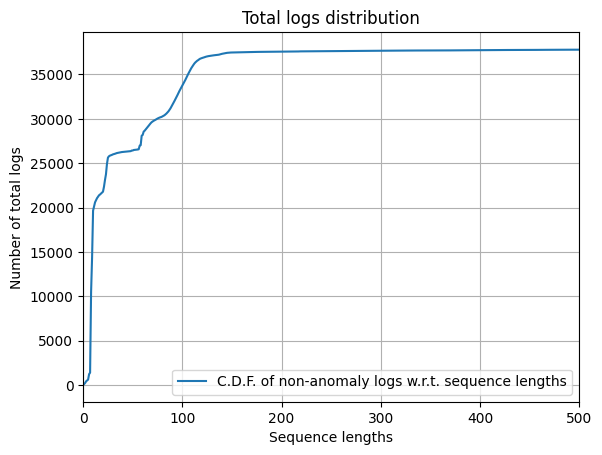

In [8]:
plt.plot(number_of_lengths, nonanomaly_logs, label = 'C.D.F. of non-anomaly logs w.r.t. sequence lengths')
plt.xlabel('Sequence lengths')  # Adjust the x-axis title
plt.ylabel('Number of total logs')  # Adjust the y-axis title
plt.title('Total logs distribution')  # Adjust the plot title

# Add a legend
plt.legend()

# Add gridlines
plt.grid(True)
plt.xlim([0,500])

# Display the plot
plt.show()

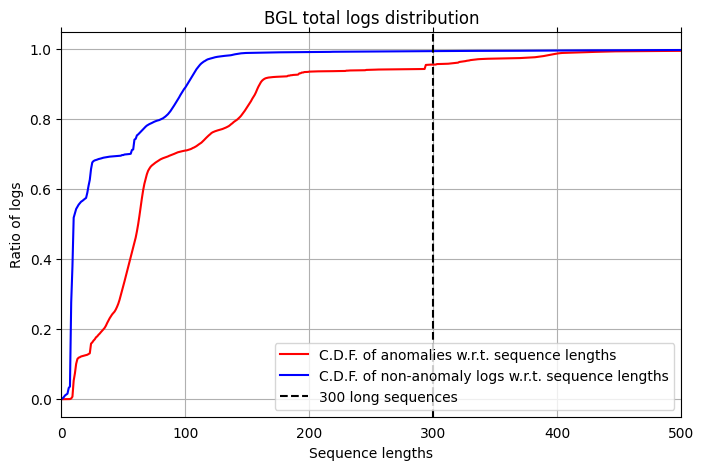

The total ratio in percents of anomalies is: 45.30
The ratio in percents of anomalies with length at least 13 is: 162.77


In [9]:
title = 'BGL total logs distribution'

plt.figure(figsize=(8, 5))  # Set figure size (width, height) in inches


plt.plot(number_of_lengths, anomalies/anomalies[-1], color='red', label = 'C.D.F. of anomalies w.r.t. sequence lengths')
plt.plot(number_of_lengths, nonanomaly_logs/nonanomaly_logs[-1], color='blue', label = 'C.D.F. of non-anomaly logs w.r.t. sequence lengths')
plt.xlabel('Sequence lengths')  # Adjust the x-axis title
plt.ylabel('Ratio of logs')  # Adjust the y-axis title

plt.title(title)  # Adjust the plot title
plt.axvline(x=300, color='black', linestyle='--', label='300 long sequences')


# Add a legend
plt.legend(loc=4)

# Add gridlines
plt.grid(True)
#plt.xlim([0,50])
#plt.axvline(x=13, color='black', linestyle='--')

plt.tick_params(axis='both', which='both', bottom=False, top=True, left=True, right=False, labelbottom=True, labelleft=True)
# Display the plot
plt.xlim([0,500])
plt.savefig('../Figures/EDA/BGL_log_distribution_plot.png', dpi=300, bbox_inches='tight')  # Save the plot

plt.show()
ratio_of_anomalies = anomalies[-1] / (nonanomaly_logs[-1]+anomalies[-1])
ratio_of_anomalies_up_13 = (anomalies[-1]-anomalies[13]) / (nonanomaly_logs[-1] - nonanomaly_logs[13])
print(f'The total ratio in percents of anomalies is: {ratio_of_anomalies*100:.2f}')
print(f'The ratio in percents of anomalies with length at least 13 is: {ratio_of_anomalies_up_13*100:.2f}')

In [ ]:
anomalies_2 = anomalies/anomalies[-1]
nonanomaly_logs_2 = nonanomaly_logs/nonanomaly_logs[-1]
lengths.sort()

In [20]:
nonanomaly_logs[-1]

np.float64(37876.0)